# Tests with only DNN and FFT

In [3]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import time
from scipy.fftpack import fft, fftfreq
import string
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Conv2D, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorboard.plugins.hparams import api as hp
tf.keras.backend.clear_session()
#%load_ext tensorboard

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from ipynb.fs.full.formata_dados import *
from ipynb.fs.full.processa_dados import *

In [4]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [8]:
#Importa os dados formatados
with open("Dataset\\dados_pickle\\dados_ok.pkl", "rb") as dados_ok:
        dados_ok = pickle.load(dados_ok)[0]
with open("Dataset\\dados_pickle\\dados_agua_ok.pkl", "rb") as dados_agua_ok:
        dados_agua_ok = pickle.load(dados_agua_ok)[0]
with open("Dataset\\dados_pickle\\dados_aspartame_ok.pkl", "rb") as dados_aspartame_ok:
        dados_aspartame_ok = pickle.load(dados_aspartame_ok)[0]
with open("Dataset\\dados_pickle\\dados_sucralose_ok.pkl", "rb") as dados_sucralose_ok:
        dados_sucralose_ok = pickle.load(dados_sucralose_ok)[0]
with open("Dataset\\dados_pickle\\dados_acucar_ok.pkl", "rb") as dados_acucar_ok:
        dados_acucar_ok = pickle.load(dados_acucar_ok)[0]
with open("Dataset\\dados_pickle\\todos_os_dados_originais.pkl", "rb") as todos_os_dados:
        dados_originais = pickle.load(todos_os_dados)[0]

In [9]:
#remove amplitudes consideradas como ruido na serie
dados_sem_ruidos = remove_ruidos(dados_ok,80) #80 - substituir valores com amplitude acima de 80
with open("Dataset\\dados_pickle\\dados_ok.pkl", "rb") as dados_ok:
    dados_ok = pickle.load(dados_ok)[0]

In [10]:
#Carrega/salva dados
gerar_dados = False
if gerar_dados == True:
    dados_sem_ruidos_separados_por_output = separa_dados_por_output(dados_sem_ruidos,dict_output)
    with open("Dataset\\dados_pickle\\dados_semruido_ok.pkl", "wb") as dados_ok_semruidos:
            pickle.dump([dados_sem_ruidos], dados_ok_semruidos)
    with open("Dataset\\dados_pickle\\dados_semruido_agua_ok.pkl", "wb") as dados_agua_ok:
            pickle.dump([dados_sem_ruidos_separados_por_output['Água']], dados_agua_ok)
    with open("Dados\\dados_pickle\\dados_semruido_aspartame_ok.pkl", "wb") as dados_aspartame_ok:
            pickle.dump([dados_sem_ruidos_separados_por_output['aspartame']], dados_aspartame_ok)
    with open("Dataset\\dados_pickle\\dados_semruido_sucralose_ok.pkl", "wb") as dados_sucralose_ok:
            pickle.dump([dados_sem_ruidos_separados_por_output['sucralose']], dados_sucralose_ok)
    with open("Dataset\\dados_pickle\\dados_semruido_acucar_ok.pkl", "wb") as dados_acucar_ok:
            pickle.dump([dados_sem_ruidos_separados_por_output['acucar']], dados_acucar_ok)
else:
    with open("Dataset\\dados_pickle\\dados_semruido_ok.pkl", "rb") as dados_ok_semruidos:
            dados_semruido_ok = pickle.load(dados_ok_semruidos)[0]
    with open("Dataset\\dados_pickle\\dados_semruido_agua_ok.pkl", "rb") as dados_agua_ok:
            dados_semruido_agua_ok= pickle.load(dados_agua_ok)[0]
    with open("Dataset\\dados_pickle\\dados_semruido_aspartame_ok.pkl", "rb") as dados_aspartame_ok:
            dados_semruido_aspartame_ok = pickle.load(dados_aspartame_ok)[0]
    with open("Dataset\\dados_pickle\\dados_semruido_sucralose_ok.pkl", "rb") as dados_sucralose_ok:
            dados_semruido_sucralose_ok = pickle.load(dados_sucralose_ok)[0]
    with open("Dataset\\dados_pickle\\dados_semruido_acucar_ok.pkl", "rb") as dados_acucar_ok:
            dados_semruido_acucar_ok = pickle.load(dados_acucar_ok)[0]

In [11]:
# gerar os vetores de input e output dos dados sem ruidos

X_all = dados_sem_ruidos[:,:-4]
y_all = dados_sem_ruidos[:,-4:]
X_all_agua = dados_semruido_agua_ok[:,:-4]
y_all_agua = dados_semruido_agua_ok[:,-4:]
X_all_acucar = dados_semruido_acucar_ok[:,:-4]
y_all_acucar = dados_semruido_acucar_ok[:,-4:]
X_all_aspartame = dados_semruido_aspartame_ok[:,:-4]
y_all_aspartame = dados_semruido_aspartame_ok[:,-4:]
X_all_sucralose = dados_semruido_sucralose_ok[:,:-4]
y_all_sucralose = dados_semruido_sucralose_ok[:,-4:]

In [12]:
def get_best(X_test, y_test, best_model):
    doce_certo, agua_certo = np.linspace(0, 1, num=101), np.linspace(0, 1, num=101)
    for i, j in enumerate(doce_certo):
        agua_certo[i], doce_certo[i] = calc_preds(j, X_test, y_test, best_model)
    b = agua_certo + doce_certo
    return b.argmax(), doce_certo[b.argmax()], agua_certo[b.argmax()], [agua_certo, doce_certo]

# Aqui começa o algoritmo

In [13]:
quant_agua, quant_acucar, quant_aspartame, quant_sucralose = X_all_agua.shape[0], X_all_acucar.shape[0], X_all_aspartame.shape[0], X_all_sucralose.shape[0]

In [14]:
s_agua = int(2*X_all_agua.shape[0]/3)
s_acucar = int(2*X_all_acucar.shape[0]/3)
s_aspartame = int(2*X_all_aspartame.shape[0]/3)
s_sucralose = int(2*X_all_sucralose.shape[0]/3)

X_all_agua_train = X_all_agua[:s_agua, :]
X_all_agua_test = X_all_agua[s_agua:, :]
X_all_acucar_train = X_all_acucar[:s_acucar, :]
X_all_acucar_test = X_all_acucar[s_acucar:, :]
X_all_aspartame_train = X_all_aspartame[:s_aspartame, :]
X_all_aspartame_test = X_all_aspartame[s_aspartame:, :]
X_all_sucralose_train = X_all_sucralose[:s_sucralose, :]
X_all_sucralose_test = X_all_sucralose[s_sucralose:, :]

# X_all_agua_train, X_all_agua_test, _, _ = train_test_split(X_all_agua, y_all_agua, test_size=0.3)
# X_all_acucar_train, X_all_acucar_test, _, _ = train_test_split(X_all_acucar, y_all_acucar, test_size=0.3)
# X_all_aspartame_train, X_all_aspartame_test, _, _ = train_test_split(X_all_aspartame, y_all_aspartame, test_size=0.3)
# X_all_sucralose_train, X_all_sucralose_test, _, _ = train_test_split(X_all_sucralose, y_all_sucralose, test_size=0.3)

window_time = 2
t_inicial = 0
delta_time = 16
n_buckets = 20

X_all_agua_train, y_all_agua_train = multiplica_dados(X_all_agua_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_agua)
X_all_acucar_train, y_all_acucar_train = multiplica_dados(X_all_acucar_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_acucar)
X_all_aspartame_train, y_all_aspartame_train = multiplica_dados(X_all_aspartame_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_aspartame)
X_all_sucralose_train, y_all_sucralose_train = multiplica_dados(X_all_sucralose_train,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_sucralose)

X_all_agua_test, y_all_agua_test = multiplica_dados(X_all_agua_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_agua)
X_all_acucar_test, y_all_acucar_test = multiplica_dados(X_all_acucar_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_acucar)
X_all_aspartame_test, y_all_aspartame_test = multiplica_dados(X_all_aspartame_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_aspartame)
X_all_sucralose_test, y_all_sucralose_test = multiplica_dados(X_all_sucralose_test,t_inicial ,t_inicial+delta_time ,512 ,window_time, 0.1, y_all_sucralose)

X_all_agua_train = converte_dados_buckets_fft(X_all_agua_train, n_buckets)
X_all_acucar_train = converte_dados_buckets_fft(X_all_acucar_train, n_buckets)
X_all_aspartame_train = converte_dados_buckets_fft(X_all_aspartame_train, n_buckets)
X_all_sucralose_train = converte_dados_buckets_fft(X_all_sucralose_train, n_buckets)

X_all_agua_test = converte_dados_buckets_fft(X_all_agua_test, n_buckets)
X_all_acucar_test = converte_dados_buckets_fft(X_all_acucar_test, n_buckets)
X_all_aspartame_test = converte_dados_buckets_fft(X_all_aspartame_test, n_buckets)
X_all_sucralose_test = converte_dados_buckets_fft(X_all_sucralose_test, n_buckets)

In [15]:
experimento = 'agua_acucar'

if experimento == 'agua_acucar':
    X_train = np.concatenate((X_all_agua_train, X_all_acucar_train))
    X_test = np.concatenate((X_all_agua_test, X_all_acucar_test))
    y_train = np.concatenate((y_all_agua_train, y_all_acucar_train))
    y_test = np.concatenate((y_all_agua_test, y_all_acucar_test))
elif experimento == 'agua_aspartame':
    X_train = np.concatenate((X_all_agua_train, X_all_aspartame_train))
    X_test = np.concatenate((X_all_agua_test, X_all_aspartame_test))
    y_train = np.concatenate((y_all_agua_train, y_all_aspartame_train))
    y_test = np.concatenate((y_all_agua_test, y_all_aspartame_test))
elif experimento == 'agua_sucralose':
    X_train = np.concatenate((X_all_agua_train, X_all_sucralose_train))
    X_test = np.concatenate((X_all_agua_test, X_all_sucralose_test))
    y_train = np.concatenate((y_all_agua_train, y_all_sucralose_train))
    y_test = np.concatenate((y_all_agua_test, y_all_sucralose_test))    
elif experimento == 'acucar_sucralose':
    X_train = np.concatenate((X_all_acucar_train, X_all_sucralose_train))
    X_test = np.concatenate((X_all_acucar_test, X_all_sucralose_test))
    y_train = np.concatenate((y_all_acucar_train, y_all_sucralose_train))
    y_test = np.concatenate((y_all_acucar_test, y_all_sucralose_test))
elif experimento == 'acucar_aspartame':
    X_train = np.concatenate((X_all_acucar_train, X_all_aspartame_train))
    X_test = np.concatenate((X_all_acucar_test, X_all_aspartame_test))
    y_train = np.concatenate((y_all_acucar_train, y_all_aspartame_train))
    y_test = np.concatenate((y_all_acucar_test, y_all_aspartame_test, ))
elif experimento == 'aspartame_sucralose':
    X_train = np.concatenate((X_all_aspartame_train, X_all_sucralose_train))
    X_test = np.concatenate((X_all_aspartame_test, X_all_sucralose_test))
    y_train = np.concatenate((y_all_aspartame_train, y_all_sucralose_train))
    y_test = np.concatenate((y_all_aspartame_test, y_all_sucralose_test))

# agua = 0
# acucar = 1
# aspartame = 2
# sucralose = 3

y_train = y_train[:,1]
y_test = y_test[:,1]    
    
if 'agua' in experimento:        # quando tempor Agua, ela é o output 0
    y_train[y_train > 0.1] = 1
    y_test[y_test > 0.1] = 1
elif 'acucar' in experimento:    # quando tempos açúcar (sem agua), ela é o output 1
    y_train[y_train > 1] = 0
    y_test[y_test > 1] = 0
else:
    print("else")
    y_train[y_train == 2] = 0      # aspartame vs sucralose: aspartame=0, sucralose=1
    y_train[y_train == 3] = 1 
    y_test[y_test == 2] = 0
    y_test[y_test == 3] = 1

# X_train = tf.keras.utils.normalize(X_train, axis=-1, order=2)
# X_test = tf.keras.utils.normalize(X_test, axis=-1, order=2)
X_train_len = X_train.shape[0]
X_all = tf.keras.utils.normalize(np.concatenate((X_train, X_test)), axis=-1, order=2)
X_train = X_all[:X_train_len,:]
X_test = X_all[X_train_len:,:]

In [23]:
y_train[1800]

1.0

In [24]:
X_train[0]

array([0.04434944, 0.06909015, 0.06719748, 0.08181626, 0.06550014,
       0.06501462, 0.05313146, 0.09424667, 0.02561683, 0.08053324,
       0.19036571, 0.84686781, 0.22278145, 0.17550473, 0.3098807 ,
       0.05767454, 0.06668427, 0.07263563, 0.10203008, 0.03664637])

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2800, 20), (2800,), (1680, 20), (1680,))

In [24]:
model = tf.keras.Sequential()
model.add(Dense(16, activation='relu')) # retified linear unit
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, epochs=100, verbose=True, shuffle=True, batch_size=512)

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4889 - accuracy: 0.7514
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4894 - accuracy: 0.7464
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4903 - accuracy: 0.7446
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.7579
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4938 - accuracy: 0.7450
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4805 - accuracy: 0.7643
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4827 - accuracy: 0.7579
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.7704
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7657
Epoch 11/100
6/6 [===========

In [31]:
# https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/#:~:text=Summarize%20Model,output%20shape%20of%20each%20layer.

In [32]:
model.evaluate(X_test, y_test, verbose=False)

[1.1774907112121582, 0.36547619104385376]

98 99.16666666666667 8.571428571428571


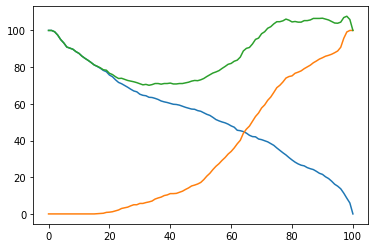

In [33]:
best, best_doce, best_agua, [agua_certo, doce_certo] = get_best(X_test, y_test, model)
print(best, best_doce, best_agua)
plt.plot(agua_certo)
plt.plot(doce_certo)
plt.plot(agua_certo + doce_certo)

In [19]:
#model.save('04_06_acucar_sucralose.h5')

In [20]:
X_test.shape

(1680, 20)

In [21]:
model.evaluate(X_test, y_test, verbose=False)

[0.6959596276283264, 0.4970238208770752]

In [34]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

def create_model_base(hp):
    model = tf.keras.Sequential()
    model.add(Dense(hp.Int('Dense_01', min_value=0, max_value=128, step=16,default=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.4, default=0.25, step=0.05)))
    model.add(Dense(hp.Int('Dense_02', min_value=0, max_value=128, step=16,default=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.4, default=0.25, step=0.05)))
    model.add(Dense(hp.Int('Dense_03', min_value=0, max_value=128, step=16,default=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.4, default=0.25, step=0.05)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_tunned_model(hp):
    model = tf.keras.Sequential()  
    model.add(Dense(hp.Int('Dense_01', min_value=16, max_value=128, step=16,default=64), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(hp.Int('Dense_02', min_value=16, max_value=128, step=16,default=64), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(create_tunned_model, objective='val_accuracy', max_trials=10, executions_per_trial=5, directory='log_dir_agua_aspartame3')

In [ ]:
tuner.search(x=X_train, y=y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models(num_models=3)[0]

In [ ]:
best_model.summary()

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)

In [ ]:
best, best_doce, best_agua, [agua_certo, doce_certo] = get_best()
print(best, best_doce, best_agua)
plt.plot(agua_certo)
plt.plot(doce_certo)
plt.plot(agua_certo + doce_certo)

In [ ]:
tf.keras.models.save_model(best_model, 'tunner01_agua_acucar_V1.h5')

In [ ]:
best_model.summary()

In [ ]:
model = return_model()

In [ ]:
model.fit(X_train, y_train, epochs=150, verbose=True, shuffle=False)  # validation_data=(X_test, y_test)

In [ ]:
#model = tf.keras.models.load_model('15_05_V3agua_acucar.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=False)

In [ ]:
print(calc_preds(0.95, X_test, y_test, model))

In [ ]:
def get_best():
    doce_certo, agua_certo = np.linspace(0, 1, num=101), np.linspace(0, 1, num=101)
    for i, j in enumerate(doce_certo):
        agua_certo[i], doce_certo[i] = calc_preds(j, X_test, y_test, model)
    b = agua_certo + doce_certo
    return b.argmax(), doce_certo[b.argmax()], agua_certo[b.argmax()], [agua_certo, doce_certo]

In [ ]:
best, best_doce, best_agua, [agua_certo, doce_certo] = get_best()
print(best, best_doce, best_agua)
plt.plot(agua_certo)
plt.plot(doce_certo)
plt.plot(agua_certo + doce_certo)

In [ ]:
#model.save('15_05_V3acucar_acucar.h5')

## First tests on the CNN

In [1]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(Dropout(hp.Float('drop1',
                                min_value=0.2,
                                max_value=0.7,
                                step=0.1)))
    model.add(Conv1D(filters=500, kernel_size=512, activation='relu', kernel_constraint=MaxNorm(1.), strides=5, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.4))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(hp.Int('Dense_last',
                                min_value=20,
                                max_value=500,
                                step=40)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation=hp.Choice('activation', ['sigmoid', 'softmax']))) # softmax
    model.compile(
        loss='categorical_crossentropy', #losses.CategoricalCrossentropy(from_logits=True), 
        optimizer='adam', 
        metrics=['accuracy'])
    # history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=512, verbose=True, shuffle=True, callbacks=[es, mc])
    return model

In [4]:
LOG_DIR = f"{int(time.time())}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs7\\hparams', histogram_freq=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

NameError: name 'EarlyStopping' is not defined

In [5]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,  
    executions_per_trial=5,  
    directory='logs7',
    logger=TensorBoardLogger(
        metrics=["val_acc"], logdir="logs7\\hparams"
    )) 
setup_tb(tuner)
tuner.search(x=X_train,
             y=y_train,
             verbose=2, 
             epochs=150,
             batch_size=32,
             callbacks=[tensorboard_callback],  
             validation_data=(X_test, y_test))

NameError: name 'RandomSearch' is not defined